# Dar Koridor Analizi: Devlet ve Toplum Gücü (1996-2023) - Versiyon 3


In [1]:
# Kütüphaneleri yükle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from factor_analyzer import FactorAnalyzer
from factor_analyzer.rotator import Rotator
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
import json
import warnings
warnings.filterwarnings('ignore')

# Görselleştirme ayarları
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Rastgele tohum
np.random.seed(42)

print("✓ Kütüphaneler yüklendi")


✓ Kütüphaneler yüklendi


## 1. Ülke Adı Eşleme Sözlüğü

WGI ve V-Dem veri setlerinde aynı ülkeler farklı isimlerle yazılmış. Bu eşlemeleri yapılandırıyoruz.


In [2]:
# Ülke adı eşleme sözlükleri
# WGI'den güncel ada
wgi_to_standard = {
    'Myanmar': 'Myanmar',
    'Czech Republic': 'Czechia',
    'Congo, Dem. Rep.': 'Democratic Republic of the Congo',
    'Congo, Rep.': 'Republic of the Congo',
    'Egypt, Arab Rep.': 'Egypt',
    'Hong Kong SAR, China': 'Hong Kong SAR (China)',
    'Iran, Islamic Rep.': 'Iran',
    'Côte d\'Ivoire': 'Côte d\'Ivoire',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'Lao PDR': 'Lao PDR',
    'Korea, Dem. Rep.': 'Democratic People\'s Republic of Korea',
    'Korea, Rep.': 'Republic of Korea',
    'São Tomé and Principe': 'São Tomé and Príncipe',
    'Slovak Republic': 'Slovakia',
    'Syrian Arab Republic': 'Syrian Arab Republic',
    'Taiwan, China': 'Taiwan',
    'Gambia, The': 'The Gambia',
    'United States': 'United States of America',
    'Venezuela, RB': 'Bolivarian Republic of Venezuela',
    'Viet Nam': 'Viet Nam',
    'Yemen, Rep.': 'Republic of Yemen'
}

# V-Dem'den güncel ada (sadece 1996+ için uygulanacak)
vdem_to_standard = {
    'Burma/Myanmar': 'Myanmar',
    'Czechia': 'Czechia',
    'Democratic Republic of the Congo': 'Democratic Republic of the Congo',
    'Republic of the Congo': 'Republic of the Congo',
    'Egypt': 'Egypt',
    'Hong Kong': 'Hong Kong SAR (China)',
    'Iran': 'Iran',
    'Ivory Coast': 'Côte d\'Ivoire',
    'Kyrgyzstan': 'Kyrgyzstan',
    'Laos': 'Lao PDR',
    'North Korea': 'Democratic People\'s Republic of Korea',
    'South Korea': 'Republic of Korea',
    'Sao Tome and Principe': 'São Tomé and Príncipe',
    'Slovakia': 'Slovakia',
    'Syria': 'Syrian Arab Republic',
    'Taiwan': 'Taiwan',
    'The Gambia': 'The Gambia',
    'United States of America': 'United States of America',
    'Venezuela': 'Bolivarian Republic of Venezuela',
    'Vietnam': 'Viet Nam',
    'Yemen': 'Republic of Yemen'
}

def normalize_country_names_wgi(df, column='countryname'):
    """WGI ülke adlarını standart hale getir"""
    df = df.copy()
    df[column] = df[column].replace(wgi_to_standard)
    return df

def normalize_country_names_vdem(df, column='country_name', year_column='year'):
    """V-Dem ülke adlarını standart hale getir (sadece 1996+)"""
    df = df.copy()
    # Sadece 1996 ve sonrası için dönüşüm yap
    mask_1996_plus = df[year_column] >= 1996
    df.loc[mask_1996_plus, column] = df.loc[mask_1996_plus, column].replace(vdem_to_standard)
    return df

print(f"✓ {len(wgi_to_standard)} WGI eşlemesi")
print(f"✓ {len(vdem_to_standard)} V-Dem eşlemesi")


✓ 21 WGI eşlemesi
✓ 21 V-Dem eşlemesi


## 2. Veri Yükleme

WGI ve V-Dem veri setlerini yüklüyoruz. Sadece gerekli sütunları alarak belleği koruyoruz.


In [3]:
# WGI verisi yükle
print("WGI verisi yükleniyor...")
wgi = pd.read_csv('../Datasets/wgidataset.csv', 
                  sep=';',
                  usecols=['countryname', 'year', 'indicator', 'estimate'])

# estimate sütunundaki virgülü noktaya çevir
wgi['estimate'] = wgi['estimate'].astype(str).str.replace(',', '.').replace('..', np.nan)
wgi['estimate'] = pd.to_numeric(wgi['estimate'], errors='coerce')

# 1996 ve sonrasını filtrele
wgi = wgi[wgi['year'] >= 1996].copy()

# Ülke adlarını normalize et
wgi = normalize_country_names_wgi(wgi)

print(f"✓ WGI: {len(wgi)} satır, {wgi['year'].min()}-{wgi['year'].max()}")
print(f"  Göstergeler: {wgi['indicator'].unique()}")
print(f"  Ülke sayısı: {wgi['countryname'].nunique()}")

# WGI veri setinin ilk birkaç satırını göster
display(wgi.head())


WGI verisi yükleniyor...
✓ WGI: 32100 satır, 1996-2023
  Göstergeler: ['cc' 'ge' 'pv' 'rl' 'rq' 'va']
  Ülke sayısı: 214


,countryname,year,indicator,estimate
0,Afghanistan,1996,cc,-1.29
1,Albania,1996,cc,-0.89
2,Algeria,1996,cc,-0.57
3,American Samoa,1996,cc,NaN
4,Andorra,1996,cc,1.32


In [4]:
# V-Dem verisi yükle (sadece gerekli sütunlar)
print("\nV-Dem verisi yükleniyor (bu biraz zaman alabilir)...")
vdem_cols = ['country_name', 'year', 'v2xcs_ccsi', 'v2x_cspart', 'v2x_freexp_altinf', 
             'v2xca_academ', 'v2caassemb', 'v2xdd_dd', 'v2x_rule', 'v2svstterr', 
             'v2stcritrecadm', 'v2x_corr', 'v2stfisccap']
vdem = pd.read_csv('../Datasets/V-Dem-CY-Full+Others-v15.csv', 
                   usecols=vdem_cols,
                   low_memory=False)

# 1996 ve sonrasını filtrele
vdem = vdem[vdem['year'] >= 1996].copy()

# Ülke adlarını normalize et (sadece 1996+)
vdem = normalize_country_names_vdem(vdem)

# Eksik değerleri kaldır
vdem_indicators = ['v2xcs_ccsi', 'v2x_cspart', 'v2x_freexp_altinf', 'v2xca_academ', 
                   'v2caassemb', 'v2xdd_dd', 'v2x_rule', 'v2svstterr', 'v2stcritrecadm', 
                   'v2x_corr', 'v2stfisccap']
vdem = vdem.dropna(subset=vdem_indicators)

print(f"✓ V-Dem: {len(vdem)} satır, {vdem['year'].min()}-{vdem['year'].max()}")
print(f"  Ülke sayısı: {vdem['country_name'].nunique()}")
print(f"  Değişkenler: {len(vdem_indicators)} gösterge")

# V-Dem veri setinin ilk birkaç satırını göster
display(vdem.head())



V-Dem verisi yükleniyor (bu biraz zaman alabilir)...
✓ V-Dem: 4869 satır, 1996-2024
  Ülke sayısı: 174
  Değişkenler: 11 gösterge


,country_name,year,v2x_freexp_altinf,v2x_cspart,v2xdd_dd,v2svstterr,v2stfisccap,v2stcritrecadm,v2caassemb,v2x_corr,v2x_rule,v2xcs_ccsi,v2xca_academ
207,Mexico,1996,0.687,0.521,0.0,95.0,1.976,0.664,0.777,0.658,0.485,0.473,0.872
208,Mexico,1997,0.687,0.574,0.0,95.8,1.976,0.664,1.422,0.639,0.503,0.520,0.872
209,Mexico,1998,0.687,0.574,0.0,95.8,1.976,0.664,1.422,0.637,0.503,0.619,0.875
210,Mexico,1999,0.687,0.611,0.0,95.8,1.976,0.664,1.422,0.637,0.503,0.671,0.859
211,Mexico,2000,0.775,0.712,0.0,90.8,1.976,0.664,2.333,0.550,0.610,0.767,0.891


## 3. Veri Hazırlığı ve Birleştirme

WGI'yi wide formata çevirip V-Dem ile birleştiriyoruz. Sadece ortak ülke-yıl kombinasyonları kalacak.


In [5]:
# WGI'yi wide formata çevir
print("WGI wide formata çeviriliyor...")
wgi_wide = wgi.pivot_table(
    index=['countryname', 'year'],
    columns='indicator',
    values='estimate'
).reset_index()

# Sütun adlarını büyük harfe çevir
wgi_wide.columns.name = None
indicator_cols = ['va', 'pv', 'ge', 'rq', 'rl', 'cc']
rename_dict = {col: col.upper() for col in indicator_cols if col in wgi_wide.columns}
wgi_wide = wgi_wide.rename(columns=rename_dict)

# pv -> PS (Political Stability)
if 'PV' in wgi_wide.columns:
    wgi_wide = wgi_wide.rename(columns={'PV': 'PS'})

print(f"✓ WGI wide: {wgi_wide.shape}")
print(f"  Sütunlar: {[c for c in wgi_wide.columns if c not in ['countryname', 'year']]}")


WGI wide formata çeviriliyor...
✓ WGI wide: (5246, 8)
  Sütunlar: ['CC', 'GE', 'PS', 'RL', 'RQ', 'VA']


In [6]:
# WGI ve V-Dem'i birleştir (inner join - sadece ortak ülke-yıl)
print("\nWGI ve V-Dem birleştiriliyor...")
merged = pd.merge(
    wgi_wide,
    vdem,
    left_on=['countryname', 'year'],
    right_on=['country_name', 'year'],
    how='inner'
)

# country_name sütununu kaldır (countryname ile aynı)
merged = merged.drop(columns=['country_name'])

# Tüm gerekli sütunları listele
required_cols = ['VA', 'PS', 'GE', 'RQ', 'RL', 'CC'] + vdem_indicators

# Eksik değerleri temizle
n_before = len(merged)
merged = merged.dropna(subset=required_cols)
n_after = len(merged)

print(f"✓ Birleştirilmiş veri: {merged.shape}")
print(f"  Ülke sayısı: {merged['countryname'].nunique()}")
print(f"  Yıl aralığı: {merged['year'].min()}-{merged['year'].max()}")
print(f"  Eksik değer temizliği: {n_before} -> {n_after} satır ({n_before-n_after} satır silindi)")

# Pandas görüntüleme ayarları
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# İlk 30 satırı göster
display(merged.head(30))



WGI ve V-Dem birleştiriliyor...
✓ Birleştirilmiş veri: (4190, 19)
  Ülke sayısı: 173
  Yıl aralığı: 1996-2023
  Eksik değer temizliği: 4203 -> 4190 satır (13 satır silindi)


,countryname,year,CC,GE,PS,RL,RQ,VA,v2x_freexp_altinf,v2x_cspart,v2xdd_dd,v2svstterr,v2stfisccap,v2stcritrecadm,v2caassemb,v2x_corr,v2x_rule,v2xcs_ccsi,v2xca_academ
0,Afghanistan,1996,-1.29,-2.18,-2.42,-1.79,-2.09,-1.91,0.041,0.041,0.020,83.667,-0.810,1.155,-0.367,0.852,0.072,0.037,0.070
1,Afghanistan,1998,-1.18,-2.10,-2.43,-1.73,-2.06,-2.04,0.038,0.041,0.020,83.667,-0.810,-1.027,-0.367,0.791,0.093,0.037,0.070
2,Afghanistan,2000,-1.27,-2.17,-2.44,-1.78,-2.08,-2.03,0.038,0.041,0.020,85.000,-0.810,-1.027,-0.367,0.791,0.093,0.037,0.070
3,Afghanistan,2002,-1.25,-1.59,-2.04,-1.67,-1.81,-1.43,0.618,0.607,0.020,73.833,-0.810,0.189,1.021,0.919,0.137,0.758,0.519
4,Afghanistan,2003,-1.34,-1.18,-2.20,-1.56,-1.46,-1.18,0.673,0.637,0.020,69.000,-0.810,0.189,1.021,0.919,0.129,0.758,0.519
5,Afghanistan,2004,-1.35,-0.95,-2.30,-1.69,-1.51,-1.20,0.667,0.645,0.020,69.000,-0.810,0.189,1.021,0.931,0.123,0.758,0.519
6,Afghanistan,2005,-1.45,-1.23,-2.07,-1.66,-1.64,-1.13,0.684,0.665,0.020,69.000,-0.810,0.189,1.006,0.942,0.117,0.725,0.519
7,Afghanistan,2006,-1.45,-1.47,-2.22,-1.88,-1.69,-1.11,0.687,0.678,0.020,66.375,-0.810,0.189,1.006,0.955,0.116,0.728,0.519
8,Afghanistan,2007,-1.61,-1.44,-2.41,-1.85,-1.71,-1.06,0.685,0.655,0.020,65.188,-0.810,0.189,1.006,0.957,0.112,0.721,0.519
9,Afghanistan,2008,-1.67,-1.53,-2.69,-1.90,-1.61,-1.17,0.716,0.655,0.020,63.500,-0.810,0.189,1.006,0.957,0.110,0.710,0.525


## 4. Standartlaştırma (Yıllık Z-Skorlama)

Her yıl içinde göstergeleri z-skoruna çeviriyoruz. Bu, farklı yılların değerlerinin karşılaştırılabilir olmasını sağlar.


In [7]:
# Tüm göstergeleri standardize et (yıl bazında)
indicators = ['VA', 'PS', 'GE', 'RQ', 'RL', 'CC'] + vdem_indicators

print("Yıllık z-skorlama uygulanıyor...")
merged_std = merged.copy()

for indicator in indicators:
    # Her yıl için ayrı ayrı standardize et
    merged_std[f'{indicator}_std'] = merged_std.groupby('year')[indicator].transform(
        lambda x: (x - x.mean()) / x.std()
    )

# Standartlaştırılmış sütunları listele
std_cols = [f'{ind}_std' for ind in indicators]

print(f"✓ {len(indicators)} gösterge standardize edildi")
print(f"  Orijinal: {indicators[:5]}... (ilk 5)")
print(f"  Standart: {std_cols[:5]}... (ilk 5)")
print(f"\n✓ Standartlaştırılmış veri özeti:")
print(merged_std[std_cols].describe().round(2))


Yıllık z-skorlama uygulanıyor...
✓ 17 gösterge standardize edildi
  Orijinal: ['VA', 'PS', 'GE', 'RQ', 'RL']... (ilk 5)
  Standart: ['VA_std', 'PS_std', 'GE_std', 'RQ_std', 'RL_std']... (ilk 5)

✓ Standartlaştırılmış veri özeti:
        VA_std   PS_std   GE_std   RQ_std   RL_std   CC_std  v2xcs_ccsi_std  \
count  4190.00  4190.00  4190.00  4190.00  4190.00  4190.00         4190.00   
mean      0.00     0.00     0.00    -0.00     0.00    -0.00           -0.00   
std       1.00     1.00     1.00     1.00     1.00     1.00            1.00   
min      -2.14    -3.20    -2.33    -2.46    -2.40    -1.80           -2.57   
25%      -0.82    -0.60    -0.72    -0.70    -0.73    -0.74           -0.70   
50%       0.02     0.08    -0.15    -0.13    -0.19    -0.24            0.42   
75%       0.77     0.79     0.66     0.73     0.67     0.56            0.81   
max       1.93     1.92     2.56     2.37     2.21     2.54            1.14   

       v2x_cspart_std  v2x_freexp_altinf_std  v2xca_academ_

## 5. Faktör Analizi

İki gizil faktörü (devlet gücü ve toplum gücü) Varimax rotasyonlu faktör analizi ile çıkarıyoruz.


In [8]:
# Faktör analizi için veri hazırla
X = merged_std[std_cols].dropna()
valid_indices = X.index

print(f"Faktör analizi hazırlığı: {X.shape[0]} gözlem, {X.shape[1]} değişken")

# Faktör analizi modeli (2 faktör, varimax rotasyon)
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(X)

# Faktör yüklerini göster
loadings = pd.DataFrame(
    fa.loadings_,
    index=indicators,
    columns=['Factor1', 'Factor2']
)

print("\n" + "="*60)
print("FAKTÖR YÜKLERİ (Varimax Rotasyon)")
print("="*60)
print(loadings.round(3))

# Her faktörün açıkladığı varyans
variance = fa.get_factor_variance()
variance_df = pd.DataFrame(
    variance,
    index=['SS Loadings', 'Proportional Var', 'Cumulative Var'],
    columns=['Factor1', 'Factor2']
)
print("\n" + "="*60)
print("AÇIKLANAN VARYANS")
print("="*60)
print(variance_df.round(3))


Faktör analizi hazırlığı: 4190 gözlem, 17 değişken

FAKTÖR YÜKLERİ (Varimax Rotasyon)
                   Factor1  Factor2
VA                   0.636    0.743
PS                   0.777    0.189
GE                   0.923    0.276
RQ                   0.841    0.405
RL                   0.924    0.319
CC                   0.907    0.280
v2xcs_ccsi           0.195    0.950
v2x_cspart           0.262    0.868
v2x_freexp_altinf    0.215    0.954
v2xca_academ         0.279    0.912
v2caassemb           0.381    0.838
v2xdd_dd             0.142    0.107
v2x_rule             0.748    0.582
v2svstterr           0.570    0.005
v2stcritrecadm       0.673    0.452
v2x_corr            -0.832   -0.342
v2stfisccap          0.631    0.392

AÇIKLANAN VARYANS
                  Factor1  Factor2
SS Loadings         7.066    5.936
Proportional Var    0.416    0.349
Cumulative Var      0.416    0.765


In [9]:
# Faktör skorlarını hesapla
factor_scores = fa.transform(X)

# Ana veri setine ekle
merged_std.loc[valid_indices, 'Factor1'] = factor_scores[:, 0]
merged_std.loc[valid_indices, 'Factor2'] = factor_scores[:, 1]

# Faktör yorumlama
print("\n" + "="*60)
print("FAKTÖR YORUMLAMA")
print("="*60)
for col in ['Factor1', 'Factor2']:
    top_vars = loadings[col].abs().sort_values(ascending=False).head(5)
    print(f"\n{col} - En yüksek yükler:")
    for var, load in top_vars.items():
        print(f"  {var:20s}: {load:6.3f}")

# Faktörleri isimlendirme
merged_std['StatePower'] = merged_std['Factor1']
merged_std['SocietyPower'] = merged_std['Factor2']

print("\n✓ Faktör skorları hesaplandı ve isimlendirildi:")
print(f"  - StatePower (Devlet Gücü)")
print(f"  - SocietyPower (Toplum Gücü)")
print(f"\n✓ Faktör skorları özeti:")
print(merged_std[['StatePower', 'SocietyPower']].describe().round(2))



FAKTÖR YORUMLAMA

Factor1 - En yüksek yükler:
  RL                  :  0.924
  GE                  :  0.923
  CC                  :  0.907
  RQ                  :  0.841
  v2x_corr            :  0.832

Factor2 - En yüksek yükler:
  v2x_freexp_altinf   :  0.954
  v2xcs_ccsi          :  0.950
  v2xca_academ        :  0.912
  v2x_cspart          :  0.868
  v2caassemb          :  0.838

✓ Faktör skorları hesaplandı ve isimlendirildi:
  - StatePower (Devlet Gücü)
  - SocietyPower (Toplum Gücü)

✓ Faktör skorları özeti:
       StatePower  SocietyPower
count     4190.00       4190.00
mean         0.00          0.00
std          0.99          0.99
min         -2.67         -2.56
25%         -0.73         -0.52
50%         -0.16          0.47
75%          0.75          0.71
max          2.66          1.19


## 6. Kümeleme Analizi

K-means ile ülkeleri gruplandırıyoruz. Önce elbow grafiği ile optimal k değerini buluyoruz.


Kümeleme için hazırlık: 4190 gözlem


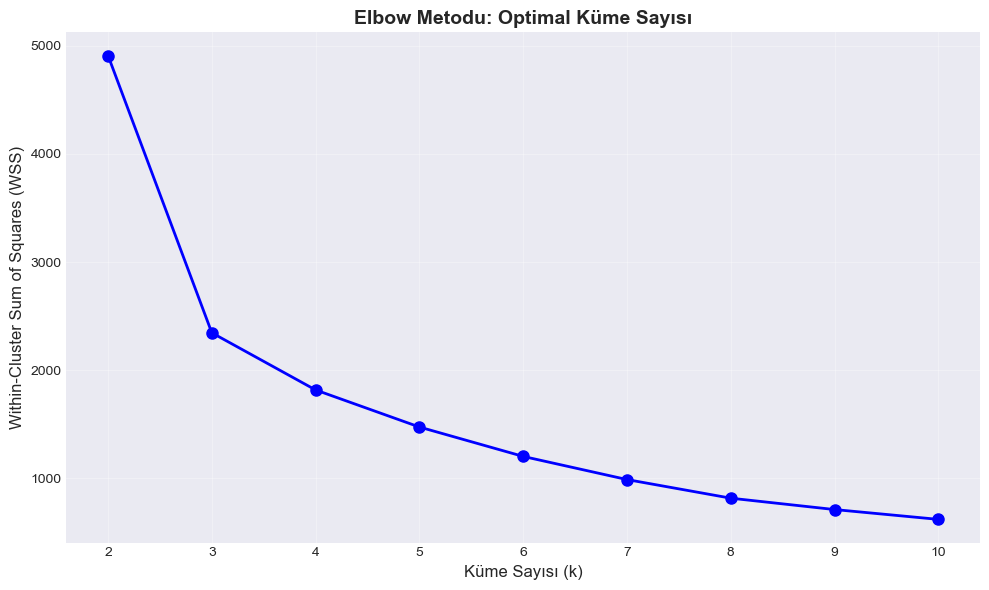

✓ Elbow grafiği oluşturuldu


In [10]:
# Kümeleme için veri hazırla
cluster_data = merged_std[['StatePower', 'SocietyPower']].dropna()
cluster_indices = cluster_data.index

print(f"Kümeleme için hazırlık: {len(cluster_data)} gözlem")

# Elbow metodu - farklı k değerleri için WSS hesapla
inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(cluster_data)
    inertias.append(kmeans.inertia_)

# Elbow grafiği
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax.set_xlabel('Küme Sayısı (k)', fontsize=12)
ax.set_ylabel('Within-Cluster Sum of Squares (WSS)', fontsize=12)
ax.set_title('Elbow Metodu: Optimal Küme Sayısı', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Elbow grafiği oluşturuldu")


In [11]:
# K=4 ile kümeleme yap
kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=20)
cluster_labels = kmeans_4.fit_predict(cluster_data)

# Ana veri setine ekle
merged_std.loc[cluster_indices, 'Cluster'] = cluster_labels

# Küme merkezlerini görüntüle
centers = pd.DataFrame(
    kmeans_4.cluster_centers_,
    columns=['StatePower', 'SocietyPower'],
    index=[f'Cluster {i}' for i in range(4)]
)

print("\n" + "="*60)
print("KÜME MERKEZLERİ (K=4)")
print("="*60)
print(centers.round(3))

# Her kümenin özelliklerini yorumla
print("\n" + "="*60)
print("KÜME YORUMLAMA")
print("="*60)
for i in range(4):
    sp = centers.loc[f'Cluster {i}', 'StatePower']
    sop = centers.loc[f'Cluster {i}', 'SocietyPower']
    count = (merged_std['Cluster'] == i).sum()
    
    # Leviathan tipini belirle
    if sp > 0.5 and sop > 0.5:
        lev_type = "Prangalanmış Leviathan (Shackled)"
    elif sp > 0.5 and sop < 0:
        lev_type = "Despotik Leviathan (Despotic)"
    elif sp < 0 and sop > 0:
        lev_type = "Mevcut Olmayan Leviathan (Absent)"
    elif sp < 0 and sop < 0:
        lev_type = "Kağıttan Leviathan (Paper)"
    else:
        lev_type = "Belirsiz"
    
    print(f"\nCluster {i}: {lev_type}")
    print(f"  StatePower:   {sp:6.3f}")
    print(f"  SocietyPower: {sop:6.3f}")
    print(f"  Gözlem sayısı: {count}")



KÜME MERKEZLERİ (K=4)
           StatePower  SocietyPower
Cluster 0      -1.152        -0.229
Cluster 1       1.190         0.611
Cluster 2      -0.447         0.619
Cluster 3       0.263        -1.713

KÜME YORUMLAMA

Cluster 0: Kağıttan Leviathan (Paper)
  StatePower:   -1.152
  SocietyPower: -0.229
  Gözlem sayısı: 756

Cluster 1: Prangalanmış Leviathan (Shackled)
  StatePower:    1.190
  SocietyPower:  0.611
  Gözlem sayısı: 1109

Cluster 2: Mevcut Olmayan Leviathan (Absent)
  StatePower:   -0.447
  SocietyPower:  0.619
  Gözlem sayısı: 1491

Cluster 3: Belirsiz
  StatePower:    0.263
  SocietyPower: -1.713
  Gözlem sayısı: 834


In [12]:
# Cluster'ları Leviathan tiplerine göre yeniden etiketle
cluster_mapping = {}

for i in range(4):
    sp = centers.loc[f'Cluster {i}', 'StatePower']
    sop = centers.loc[f'Cluster {i}', 'SocietyPower']
    
    if sp > 0.5 and sop > 0.5:
        cluster_mapping[i] = "Shackled"
    elif sp > 0.5 and sop < -0.3:
        cluster_mapping[i] = "Despotic"
    elif sp < -0.3 and sop < -0.3:
        cluster_mapping[i] = "Paper"
    elif sp < 0 and sop > 0.5:
        cluster_mapping[i] = "Absent"
    else:
        # Daha esnek kriterler
        if sp > sop and sp > 0:
            cluster_mapping[i] = "Despotic"
        elif sop > sp and abs(sp) < 1 and abs(sop) < 1:
            cluster_mapping[i] = "Paper"
        elif sp > 0 and sop > 0:
            cluster_mapping[i] = "Shackled"
        else:
            cluster_mapping[i] = "Paper"

merged_std['LeviathanType'] = merged_std['Cluster'].map(cluster_mapping)

print("\n✓ Leviathan tipleri etiketlendi:")
print(merged_std['LeviathanType'].value_counts())
print(f"\n✓ Cluster -> Leviathan eşlemesi:")
for k, v in cluster_mapping.items():
    print(f"  Cluster {k} -> {v}")



✓ Leviathan tipleri etiketlendi:
LeviathanType
Absent      1491
Shackled    1109
Despotic     834
Paper        756
Name: count, dtype: int64

✓ Cluster -> Leviathan eşlemesi:
  Cluster 0 -> Paper
  Cluster 1 -> Shackled
  Cluster 2 -> Absent
  Cluster 3 -> Despotic


## 7. Görselleştirme: 1996 ve 2022 Karşılaştırması

Dar Koridor grafiklerini oluşturuyoruz. 1996'da ülkelerin konumu ile 2022'deki konumlarını karşılaştırıyoruz.


1996: 152 ülke
2022: 173 ülke


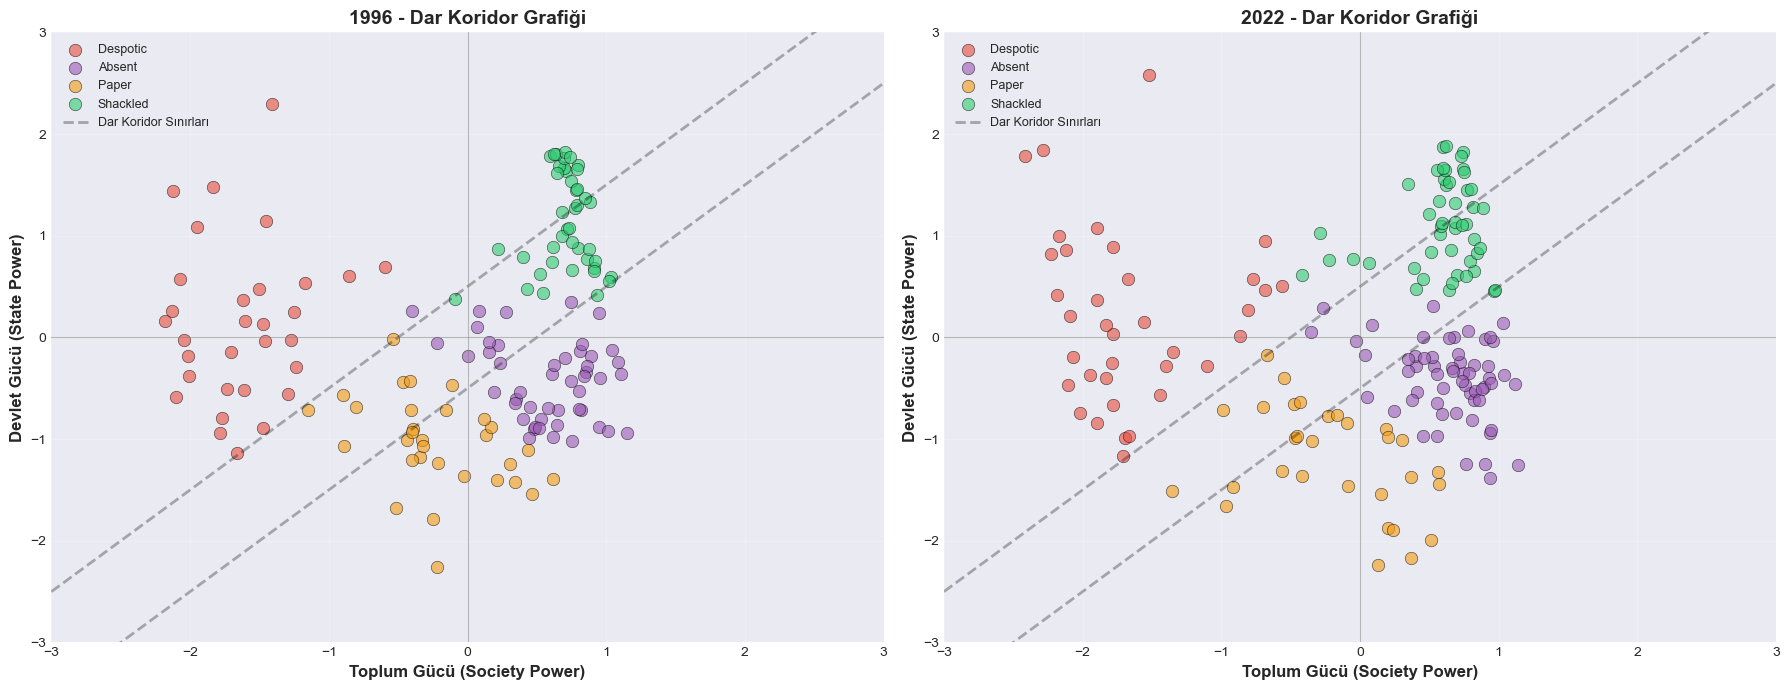


✓ 1996 ve 2022 Dar Koridor grafikleri oluşturuldu


In [13]:
# 1996 ve 2022 verilerini hazırla
data_1996 = merged_std[merged_std['year'] == 1996].copy()
data_2022 = merged_std[merged_std['year'] == 2022].copy()

print(f"1996: {len(data_1996)} ülke")
print(f"2022: {len(data_2022)} ülke")

# Renk paleti
color_map = {
    'Shackled': '#2ecc71',  # Yeşil
    'Despotic': '#e74c3c',  # Kırmızı
    'Paper': '#f39c12',     # Turuncu
    'Absent': '#9b59b6'     # Mor
}

# 1996 ve 2022 grafikleri
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for idx, (year, data) in enumerate([(1996, data_1996), (2022, data_2022)]):
    ax = axes[idx]
    
    # Her Leviathan tipi için ayrı scatter
    for lev_type in data['LeviathanType'].unique():
        if pd.isna(lev_type):
            continue
        subset = data[data['LeviathanType'] == lev_type]
        ax.scatter(subset['SocietyPower'], subset['StatePower'],
                  c=color_map.get(lev_type, 'gray'),
                  label=lev_type, alpha=0.6, s=80, edgecolors='black', linewidth=0.5)
    
    # Dar Koridor çizgileri (yaklaşık)
    x_corr = np.linspace(-3, 3, 100)
    y_upper = x_corr + 0.5  # Üst sınır
    y_lower = x_corr - 0.5  # Alt sınır
    ax.plot(x_corr, y_upper, 'k--', alpha=0.3, linewidth=2, label='Dar Koridor Sınırları')
    ax.plot(x_corr, y_lower, 'k--', alpha=0.3, linewidth=2)
    
    # Eksen ve grid
    ax.axhline(0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    ax.axvline(0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    ax.grid(True, alpha=0.2)
    
    # Etiketler
    ax.set_xlabel('Toplum Gücü (Society Power)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Devlet Gücü (State Power)', fontsize=12, fontweight='bold')
    ax.set_title(f'{year} - Dar Koridor Grafiği', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=9, framealpha=0.9)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)

plt.tight_layout()
plt.show()

print("\n✓ 1996 ve 2022 Dar Koridor grafikleri oluşturuldu")


In [14]:
# İnteraktif Plotly grafiği (2022)
fig = px.scatter(
    data_2022,
    x='SocietyPower',
    y='StatePower',
    color='LeviathanType',
    hover_name='countryname',
    hover_data={'StatePower': ':.2f', 'SocietyPower': ':.2f', 'LeviathanType': True},
    title='2022 - Dar Koridor: Devlet ve Toplum Gücü (İnteraktif)',
    color_discrete_map=color_map,
    labels={
        'StatePower': 'Devlet Gücü',
        'SocietyPower': 'Toplum Gücü',
        'LeviathanType': 'Leviathan Tipi'
    }
)

# Dar Koridor çizgileri ekle
x_line = np.linspace(-3, 3, 50)
fig.add_trace(go.Scatter(x=x_line, y=x_line + 0.5, mode='lines',
                         line=dict(color='black', dash='dash', width=2),
                         name='Dar Koridor (Üst)', showlegend=False))
fig.add_trace(go.Scatter(x=x_line, y=x_line - 0.5, mode='lines',
                         line=dict(color='black', dash='dash', width=2),
                         name='Dar Koridor (Alt)', showlegend=False))

# Eksen çizgileri
fig.add_hline(y=0, line_dash="solid", line_color="gray", opacity=0.3)
fig.add_vline(x=0, line_dash="solid", line_color="gray", opacity=0.3)

fig.update_layout(
    width=900,
    height=700,
    xaxis=dict(range=[-3, 3], title_font=dict(size=14)),
    yaxis=dict(range=[-3, 3], title_font=dict(size=14)),
    font=dict(size=12),
    hovermode='closest'
)

fig.show()

print("\n✓ İnteraktif Plotly grafiği oluşturuldu")



✓ İnteraktif Plotly grafiği oluşturuldu


## 8. Freedom House Karşılaştırması (2022)

Modelimizin bulduğu Leviathan tiplerini Freedom House'un rejim sınıflandırmasıyla karşılaştırıyoruz.


In [15]:
# Freedom House verisini yükle
print("Freedom House verisi yükleniyor...")
fh = pd.read_csv('../Datasets/FIW13-25-Tablo 1.csv', sep=';', skiprows=1)

# 2025 verisini filtrele (en güncel)
fh_2025 = fh[fh['Edition'] == 2025].copy()

# Sadece country (c) olanları al, territory (t) hariç
fh_2025 = fh_2025[fh_2025['C/T'] == 'c'].copy()

# Ülke adlarını normalize et
fh_2025['Country/Territory'] = fh_2025['Country/Territory'].str.strip()

print(f"✓ Freedom House 2025: {len(fh_2025)} ülke")
print(f"  Status kategorileri: {fh_2025['Status'].unique()}")
print(f"  F=Free, PF=Partly Free, NF=Not Free")


Freedom House verisi yükleniyor...
✓ Freedom House 2025: 195 ülke
  Status kategorileri: ['NF' 'PF' 'F']
  F=Free, PF=Partly Free, NF=Not Free


In [16]:
# 2022 verilerimizle birleştir
comparison = pd.merge(
    data_2022,
    fh_2025[['Country/Territory', 'Status']],
    left_on='countryname',
    right_on='Country/Territory',
    how='inner'
)

print(f"\n✓ Eşleşen ülke sayısı: {len(comparison)}")

# Çapraz tablo
crosstab = pd.crosstab(
    comparison['LeviathanType'],
    comparison['Status'],
    margins=True
)

print("\n" + "="*60)
print("LEVIATHAN TİPİ vs FREEDOM HOUSE STATUS (2022/2025)")
print("="*60)
print(crosstab)

# Yüzde tablosu
crosstab_pct = pd.crosstab(
    comparison['LeviathanType'],
    comparison['Status'],
    normalize='index'
) * 100

print("\n" + "="*60)
print("YÜZDE DAĞILIM (Satır bazında)")
print("="*60)
print(crosstab_pct.round(1))



✓ Eşleşen ülke sayısı: 158

LEVIATHAN TİPİ vs FREEDOM HOUSE STATUS (2022/2025)
Status          F  NF  PF  All
LeviathanType                 
Absent         18   4  35   57
Despotic        0  27   4   31
Paper           0  17   9   26
Shackled       42   0   2   44
All            60  48  50  158

YÜZDE DAĞILIM (Satır bazında)
Status            F    NF    PF
LeviathanType                  
Absent         31.6   7.0  61.4
Despotic        0.0  87.1  12.9
Paper           0.0  65.4  34.6
Shackled       95.5   0.0   4.5


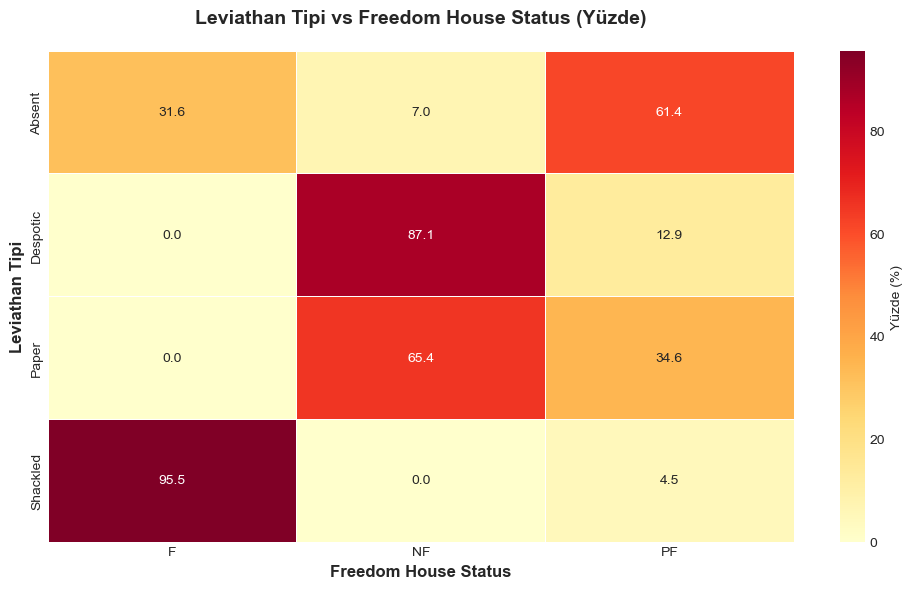


✓ Karşılaştırma ısı haritası oluşturuldu


In [17]:
# Isı haritası
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(crosstab_pct, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Yüzde (%)'}, linewidths=0.5,
            ax=ax)
ax.set_title('Leviathan Tipi vs Freedom House Status (Yüzde)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Freedom House Status', fontsize=12, fontweight='bold')
ax.set_ylabel('Leviathan Tipi', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Karşılaştırma ısı haritası oluşturuldu")


## 9. Veri Eksportu

Hesaplanan faktör skorlarını ve kümeleri CSV ve JSON formatlarında kaydediyoruz.


In [18]:
# Tüm yıllar için CSV eksportu
export_cols = ['countryname', 'year', 'StatePower', 'SocietyPower', 'Cluster', 'LeviathanType']
export_df = merged_std[export_cols].copy()

# Eksik değerleri temizle
export_df = export_df.dropna(subset=['StatePower', 'SocietyPower'])

# CSV olarak kaydet
output_csv = '../Datasets/processed3/factor_scores_1996_2022.csv'
export_df.to_csv(output_csv, index=False)

print(f"✓ Tüm yıllar CSV'ye kaydedildi: {output_csv}")
print(f"  Toplam {len(export_df)} gözlem ({export_df['countryname'].nunique()} ülke)")
print(f"  Yıl aralığı: {export_df['year'].min()}-{export_df['year'].max()}")


✓ Tüm yıllar CSV'ye kaydedildi: ../Datasets/processed3/factor_scores_1996_2022.csv
  Toplam 4190 gözlem (173 ülke)
  Yıl aralığı: 1996-2023


In [19]:
# 2022 verisini JSON formatında kaydet (web paneli için)
data_2022_export = data_2022[['countryname', 'StatePower', 'SocietyPower', 
                               'LeviathanType', 'Cluster']].copy()
data_2022_export = data_2022_export.dropna()

# JSON yapısını oluştur
json_output = {
    'year': 2022,
    'countries': []
}

for _, row in data_2022_export.iterrows():
    json_output['countries'].append({
        'name': row['countryname'],
        'statePower': round(float(row['StatePower']), 3),
        'societyPower': round(float(row['SocietyPower']), 3),
        'leviathanType': row['LeviathanType'],
        'cluster': int(row['Cluster'])
    })

# JSON olarak kaydet
output_json = '../Datasets/processed3/dar_koridor_latest_2022.json'
with open(output_json, 'w', encoding='utf-8') as f:
    json.dump(json_output, f, ensure_ascii=False, indent=2)

print(f"\n✓ 2022 verisi JSON'a kaydedildi: {output_json}")
print(f"  {len(json_output['countries'])} ülke")

# İlk 3 ülkeyi göster
print(f"\n✓ JSON yapısı (ilk 3 ülke):")
for country in json_output['countries'][:3]:
    print(f"  {country['name']}: SP={country['statePower']}, SoP={country['societyPower']}, Type={country['leviathanType']}")



✓ 2022 verisi JSON'a kaydedildi: ../Datasets/processed3/dar_koridor_latest_2022.json
  173 ülke

✓ JSON yapısı (ilk 3 ülke):
  Afghanistan: SP=-0.986, SoP=-1.693, Type=Despotic
  Albania: SP=0.003, SoP=0.453, Type=Absent
  Algeria: SP=-0.28, SoP=-1.102, Type=Despotic


## 10. Özet ve Bulgular

Analiz tamamlandı. Aşağıda temel bulguları özetliyoruz.


In [20]:
print("="*70)
print("ANALİZ ÖZET RAPORU")
print("="*70)

print(f"\n📊 VERİ KAPSAMI:")
print(f"  • Yıl aralığı: {export_df['year'].min()}-{export_df['year'].max()}")
print(f"  • Toplam gözlem: {len(export_df)}")
print(f"  • Ülke sayısı: {export_df['countryname'].nunique()}")

print(f"\n🔍 FAKTÖR ANALİZİ:")
print(f"  • 2 faktör çıkarıldı (Devlet Gücü, Toplum Gücü)")
print(f"  • Toplam varyans açıklama: {variance_df.loc['Cumulative Var', 'Factor2']:.1%}")
print(f"  • Rotasyon: Varimax")
print(f"  • Kullanılan gösterge sayısı: {len(indicators)}")

print(f"\n🎯 KÜMELEME (K=4):")
for lev_type in export_df['LeviathanType'].unique():
    if pd.notna(lev_type):
        count = (export_df['LeviathanType'] == lev_type).sum()
        pct = count / len(export_df) * 100
        print(f"  • {lev_type}: {count} gözlem ({pct:.1f}%)")

print(f"\n📈 1996 vs 2022 KARŞILAŞTIRMASI:")
print(f"  • 1996: {len(data_1996)} ülke")
print(f"  • 2022: {len(data_2022)} ülke")

print(f"\n✅ ÇIKTILAR:")
print(f"  • CSV: {output_csv}")
print(f"  • JSON: {output_json}")

print("\n" + "="*70)
print("Analiz başarıyla tamamlandı!")
print("="*70)


ANALİZ ÖZET RAPORU

📊 VERİ KAPSAMI:
  • Yıl aralığı: 1996-2023
  • Toplam gözlem: 4190
  • Ülke sayısı: 173

🔍 FAKTÖR ANALİZİ:
  • 2 faktör çıkarıldı (Devlet Gücü, Toplum Gücü)
  • Toplam varyans açıklama: 76.5%
  • Rotasyon: Varimax
  • Kullanılan gösterge sayısı: 17

🎯 KÜMELEME (K=4):
  • Despotic: 834 gözlem (19.9%)
  • Paper: 756 gözlem (18.0%)
  • Absent: 1491 gözlem (35.6%)
  • Shackled: 1109 gözlem (26.5%)

📈 1996 vs 2022 KARŞILAŞTIRMASI:
  • 1996: 152 ülke
  • 2022: 173 ülke

✅ ÇIKTILAR:
  • CSV: ../Datasets/processed3/factor_scores_1996_2022.csv
  • JSON: ../Datasets/processed3/dar_koridor_latest_2022.json

Analiz başarıyla tamamlandı!
